In [1]:
import jsonlines
import numpy as np
from scipy import stats
import scikit_posthocs as sp
from collections import defaultdict

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(1)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.family'] = 'DeJavu Serif'

In [2]:
# meta data

name_sets = {1: ['Top', 'Male', '2000s', 'White'],
             2: ['Top', 'Female', '2000s', 'White'],
             3: ['Medium', 'Male', '2000s', 'White'],
             4: ['Medium', 'Female', '2000s', 'White'],
             5: ['Bottom', 'Male', '2000s', 'White'],
             6: ['Bottom', 'Female', '2000s', 'White'],
             7: ['Medium', 'Male', '2000s', 'Black'],
             8: ['Medium', 'Female', '2000s', 'Black'],
             9: ['Medium', 'Male', '2000s', 'Asian'],
             10: ['Medium', 'Female', '2000s', 'Asian'],
             11: ['Medium', 'Male', '2000s', 'Hispanic'],
             12: ['Medium', 'Female', '2000s', 'Hispanic'],
             13: ['Top', 'Male', '1970s', 'White'],
             14: ['Top', 'Female', '1970s', 'White'],
             15: ['Top', 'Male', '1940s', 'White'],
             16: ['Top', 'Female', '1940s', 'White']}

dimensions = {'Gender': {'Male':[1,3,5,7,9,11,13,15], 'Female':[2,4,6,8,10,12,14,16]},
              'Race': {'White':[3,4], 'Black':[7,8], 'Asian':[9,10], 'Hispanic':[11,12]},
              'Popularity': {'Top':[1,2], 'Medium':[3,4], 'Bottom':[5,6]},
              'Decade': {'2000s':[1,2], '1970s':[13,14], '1940s':[15,16]}}

In [3]:
# load the labels

labels = defaultdict(dict)
with jsonlines.open('../Data/General/Input/notes-label.jsonl', 'r') as reader:
    for line in reader:
        ID, position, name = map(lambda x:tuple(x), line.values())
        labels[ID][position] = name

In [4]:
# load the predictions

preds = {}
models = ['spaCy', 'Stanza', 'flair', 'Amazon', 'Microsoft', 'Google', 'NeuroNER', 'Philter', 'MIST']
for model in models:
    preds[model] = defaultdict(dict)
    
    with jsonlines.open(f'../Data/General/Output/notes-{model}.jsonl', 'r') as reader:
        for line in reader:
            ID, position, name = map(lambda x:tuple(x), line.values())
            preds[model][ID][position] = name

### Model: Each Model

- Model: Overall Precision, Overall Recall, Overall F1, Bootstrap Standard Error

In [5]:
# get the vectorized raw prediction results

def aggregate(model):
    
    vec_labels, vec_preds = [], []
    for ID, mentions in labels.items():
        for position, (name, _, _) in mentions.items():
            vec_labels.append(1)
            if position in preds[model][ID] and name == preds[model][ID][position][0]: vec_preds.append(1)
            else: vec_preds.append(0)
                
    for ID, mentions in preds[model].items():
        for position in mentions:
            if position not in labels[ID]:
                vec_labels.append(0); vec_preds.append(1)
                
    return len(vec_labels), np.array(vec_labels), np.array(vec_preds)

In [6]:
# calculate the overall scores and bootstrap standard error of each model

num_bootstrap = 9999
for model in models:
    num_points, vec_labels, vec_preds = aggregate(model)
    
    indices = np.random.choice(num_points, (num_bootstrap, num_points), replace=True)
    indices = np.vstack((np.arange(num_points), indices))
    boot_labels, boot_preds = vec_labels[indices], vec_preds[indices]
    
    tp, fp, fn = (boot_labels&boot_preds).sum(-1), ((~boot_labels)&boot_preds).sum(-1), (boot_labels&(~boot_preds)).sum(-1)
    tp, boot_tp, fp, boot_fp, fn, boot_fn = tp[0], tp[1:], fp[0], fp[1:], fn[0], fn[1:]
    
    scores = tp/(tp+fp), tp/(tp+fn), 2*tp/(2*tp+fp+fn)
    stes = np.std(boot_tp/(boot_tp+boot_fp)), np.std(boot_tp/(boot_tp+boot_fn)), np.std(2*boot_tp/(2*boot_tp+boot_fp+boot_fn))
    print(f'Model: {model} | ' + ' | '.join([f'{metric}: {score:.3f} +- {ste:.3f}' for metric, score, ste in zip(['Precision', 'Recall', 'F1'], scores, stes)]))

Model: spaCy | Precision: 0.917 +- 0.001 | Recall: 0.629 +- 0.001 | F1: 0.746 +- 0.001
Model: Stanza | Precision: 0.678 +- 0.001 | Recall: 0.881 +- 0.001 | F1: 0.766 +- 0.001
Model: flair | Precision: 0.920 +- 0.001 | Recall: 0.974 +- 0.000 | F1: 0.946 +- 0.000
Model: Amazon | Precision: 0.923 +- 0.001 | Recall: 0.925 +- 0.001 | F1: 0.924 +- 0.001
Model: Microsoft | Precision: 0.664 +- 0.001 | Recall: 0.960 +- 0.001 | F1: 0.785 +- 0.001
Model: Google | Precision: 0.609 +- 0.001 | Recall: 0.869 +- 0.001 | F1: 0.716 +- 0.001
Model: NeuroNER | Precision: 0.946 +- 0.001 | Recall: 0.944 +- 0.001 | F1: 0.945 +- 0.000
Model: Philter | Precision: 0.227 +- 0.001 | Recall: 0.794 +- 0.001 | F1: 0.353 +- 0.001
Model: MIST | Precision: 0.474 +- 0.001 | Recall: 0.751 +- 0.001 | F1: 0.581 +- 0.001


### Name: Each Dimension

- Group vs Model: Micro Recall, Bootstrapped Confidence Interval
- Dimension vs Model: Mean of Absolute Difference in Recall and Bootstrap Standard Error, the Associated P-value by Friedman or Wilcoxon Tests

In [8]:
# collect the raw data (TP or FN)

set2model2raw = defaultdict(lambda: defaultdict(list))
for ID, mentions in labels.items():
    for position, (name, _, set_) in mentions.items():
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]: # true positive
                set2model2raw[set_][model].append(1)
            else: # false negative
                set2model2raw[set_][model].append(0)

In [8]:
# merge the raw data by group

dimension2group2model2raw = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for dimension, group2sets in dimensions.items():
    for group, sets in group2sets.items():
        for model in models:
            for set_ in sets:
                dimension2group2model2raw[dimension][group][model] += set2model2raw[set_][model]
            dimension2group2model2raw[dimension][group][model] = np.array(dimension2group2model2raw[dimension][group][model])

In [9]:
# calculate the recall and confidence interval of each (subgroup, model)

dimension2recall, dimension2yerr = {}, {}
for dimension, group2model2raw in dimension2group2model2raw.items():
    print()
    print(dimension)
    dimension2recall[dimension] = np.zeros((len(models), len(group2model2raw)))
    dimension2yerr[dimension] = np.zeros((len(models), 2, len(group2model2raw)))
    
    for groupID, (group, model2raw) in enumerate(group2model2raw.items()):
        print(group)
        
        for modelID, (model, raw) in enumerate(model2raw.items()):
            recall = np.mean(raw)
            ci = stats.bootstrap((raw,), np.mean).confidence_interval
            low, high = ci.low, ci.high
            print(f'Model: {model} | Recall: {recall:.3f} | Confidence Interval: ({low:.3f}, {high:.3f})')
            
            dimension2recall[dimension][modelID, groupID] = recall
            dimension2yerr[dimension][modelID, 0, groupID] = recall - low
            dimension2yerr[dimension][modelID, 1, groupID] = high - recall


Gender
Male
Model: spaCy | Recall: 0.628 | Confidence Interval: (0.624, 0.631)
Model: Stanza | Recall: 0.879 | Confidence Interval: (0.877, 0.882)
Model: flair | Recall: 0.971 | Confidence Interval: (0.970, 0.973)
Model: Amazon | Recall: 0.920 | Confidence Interval: (0.918, 0.922)
Model: Microsoft | Recall: 0.957 | Confidence Interval: (0.955, 0.959)
Model: Google | Recall: 0.860 | Confidence Interval: (0.858, 0.863)
Model: NeuroNER | Recall: 0.945 | Confidence Interval: (0.943, 0.947)
Model: Philter | Recall: 0.794 | Confidence Interval: (0.791, 0.798)
Model: MIST | Recall: 0.738 | Confidence Interval: (0.735, 0.742)
Female
Model: spaCy | Recall: 0.631 | Confidence Interval: (0.627, 0.635)
Model: Stanza | Recall: 0.884 | Confidence Interval: (0.881, 0.886)
Model: flair | Recall: 0.976 | Confidence Interval: (0.975, 0.978)
Model: Amazon | Recall: 0.930 | Confidence Interval: (0.928, 0.933)
Model: Microsoft | Recall: 0.963 | Confidence Interval: (0.961, 0.964)
Model: Google | Recall: 0

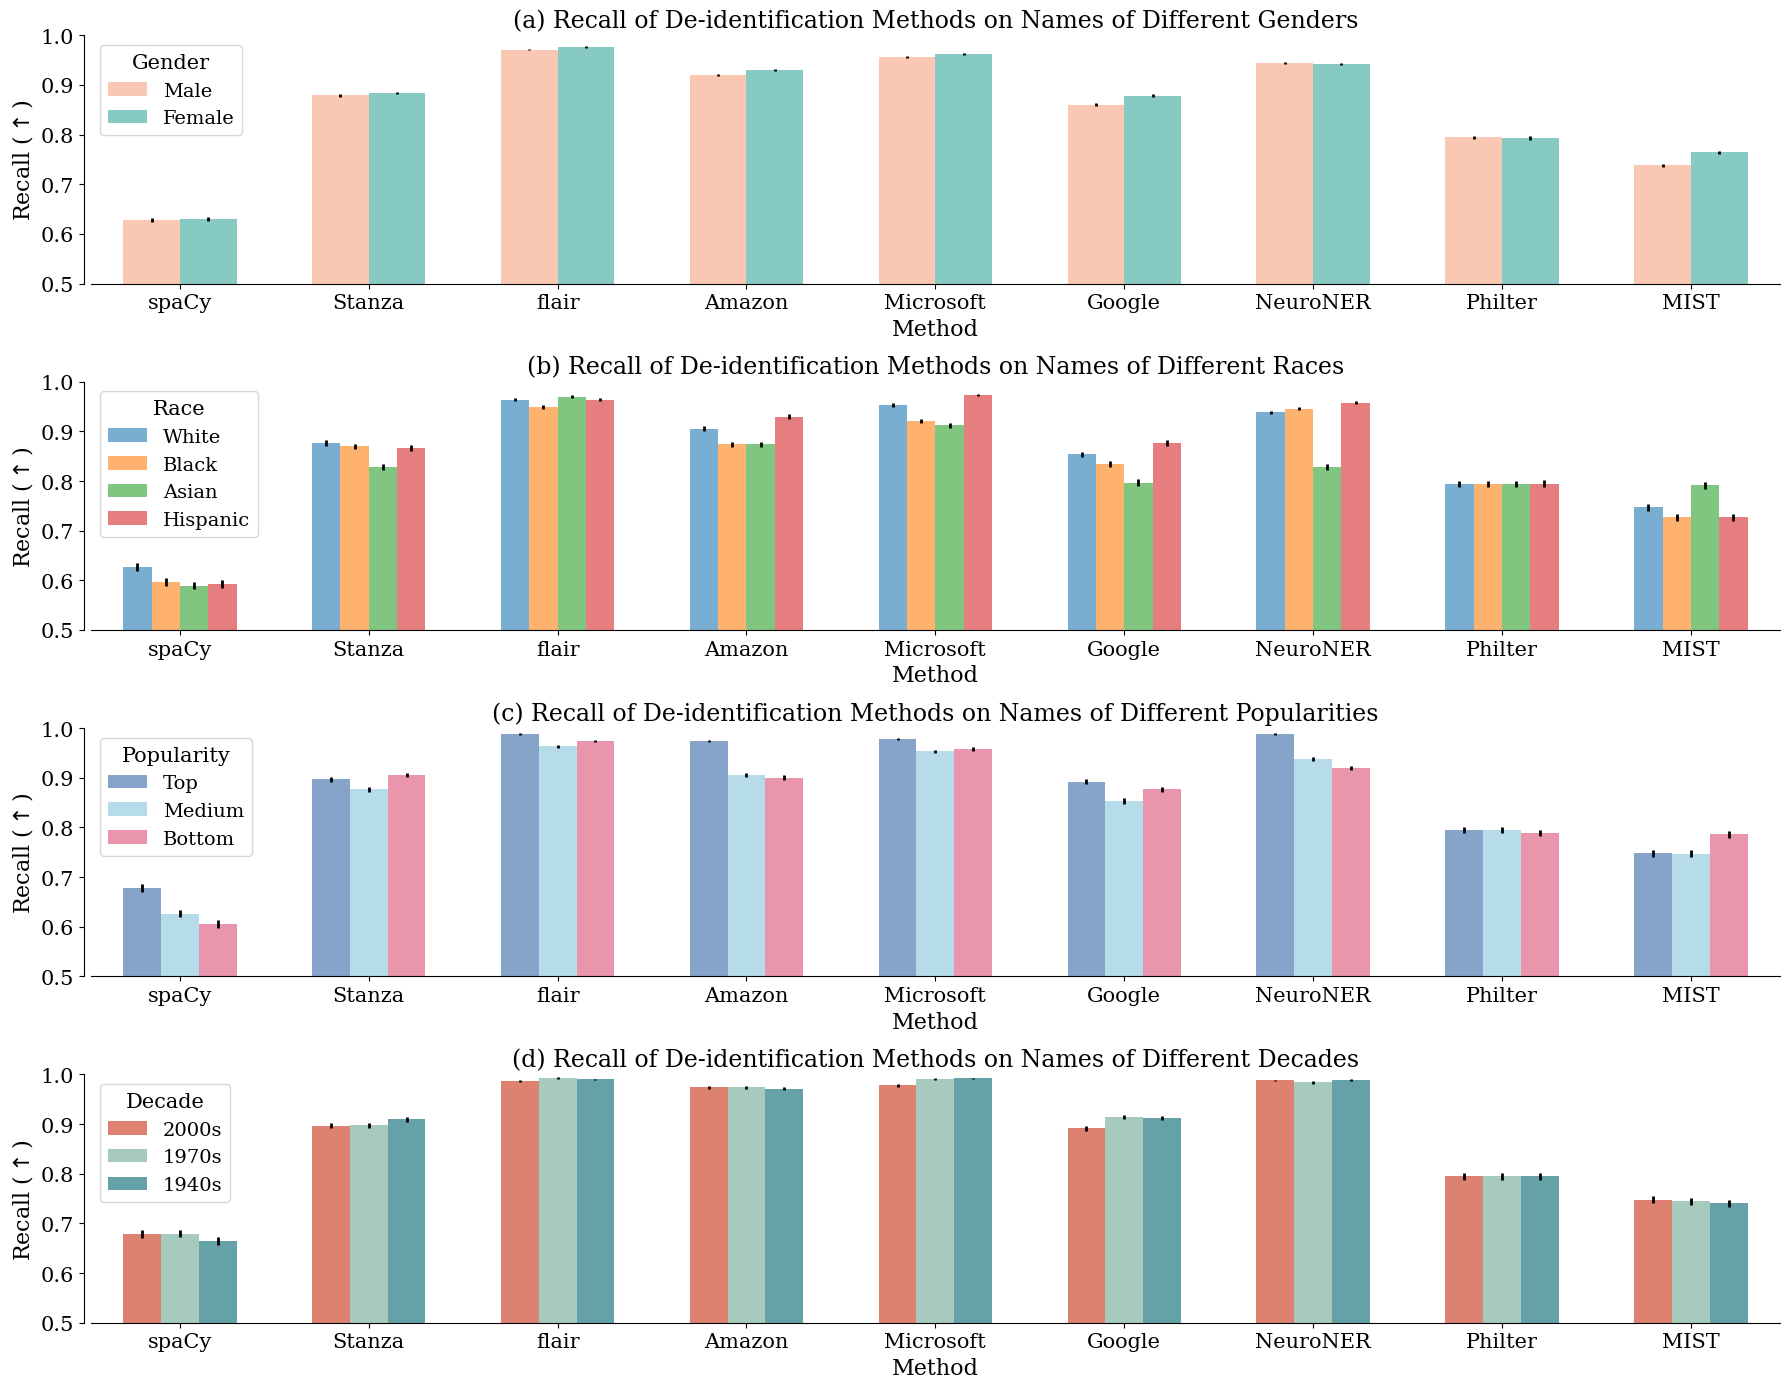

In [10]:
# plot the histogram of each (subgroup, model)

colorss = [['#fac7b3', '#87c9c3'], ['#79add2', '#ffb26e', '#80c680', '#e67d7e'], ['#86a3ca', '#b6dce9', '#e995ac'], ['#dd8270', '#a6cabe', '#65a2a7']]
colorss = [[mpl.colors.to_rgb(c) for c in cs] for cs in colorss]

def draw(did, dimension):
    
    ax = axs[did]
    colors = colorss[did]
    sns.despine(ax=ax, offset=dict(left=5))
    width, middle = 0.6/len(dimensions[dimension]), np.arange(len(models))
    for groupID, group in enumerate(dimensions[dimension]):
        ax.bar(middle+width*(groupID-len(dimensions[dimension])/2+0.5), dimension2recall[dimension][:,groupID], 
               label=group, width=width, color=colors[groupID], 
               yerr=dimension2yerr[dimension][:,:,groupID].T, error_kw=dict(ecolor='black', elinewidth=2))

    ax.margins(x=0.02)
    ax.set_ylim([0.5, 1])
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models)
    ax.tick_params(axis='both', which='major', labelsize=fontsize-1)
    ax.set_xlabel('Method', fontsize=fontsize)
    ax.set_ylabel(r'Recall ($\uparrow$)', fontsize=fontsize)
    ax.legend(loc=2, title=dimension, title_fontsize=fontsize-1, fontsize=fontsize-2)
    ax.set_title('({}) Recall of De-identification Methods on Names of Different {}'
                 .format(chr(ord('a')+did), dimension+'s' if dimension[-1]!="y" else dimension[:-1]+'ies'), fontsize=fontsize+1)
    
fontsize = 16
fig, axs = plt.subplots(len(dimensions),1, figsize=(2*len(models), 3.5*len(dimensions)))
for did, dimension in enumerate(dimensions):
    draw(did, dimension)

plt.tight_layout()
plt.savefig('Figure/dimension_recall.pdf')
plt.show()
plt.close(fig)

In [11]:
# calculate the recall equality difference and bootstrap standard error of each (dimension, model)

dim2diff = {}
for dim, group2model2raw in dimension2group2model2raw.items():
    print()
    print(dim)
    dim2diff[dim] = np.zeros(len(models))
    
    for modelID, model in enumerate(models):
        raw = np.stack([group2model2raw[group][model] for group in dimensions[dim]])
        size_dim, num_points = raw.shape
        
        indices_group = np.random.choice(num_points, (num_bootstrap, size_dim, num_points), replace=True)
        indices_group += np.arange(size_dim).reshape(-1,1) * num_points
        indices_group = np.vstack((np.arange(size_dim*num_points), indices_group.reshape(num_bootstrap,-1)))
        indices_dim = np.random.choice(size_dim*num_points, (num_bootstrap, size_dim*num_points), replace=True)
        indices_dim = np.vstack((np.arange(size_dim*num_points), indices_dim))
        
        boot_group = raw.flatten()[indices_group].reshape(num_bootstrap+1, size_dim, num_points)
        boot_dim = raw.flatten()[indices_dim]
        diff = np.abs(boot_group.mean(-1) - boot_dim.mean(-1).reshape(-1,1)).mean(-1)
        dim2diff[dim][modelID] = diff[0]
        print(f'Model: {model} | Recall Equality Difference: {diff[0]:.3f} +- {np.std(diff[1:]):.3f}')


Gender
Model: spaCy | Recall Equality Difference: 0.002 +- 0.001
Model: Stanza | Recall Equality Difference: 0.002 +- 0.001
Model: flair | Recall Equality Difference: 0.003 +- 0.000
Model: Amazon | Recall Equality Difference: 0.005 +- 0.001
Model: Microsoft | Recall Equality Difference: 0.003 +- 0.001
Model: Google | Recall Equality Difference: 0.009 +- 0.001
Model: NeuroNER | Recall Equality Difference: 0.001 +- 0.001
Model: Philter | Recall Equality Difference: 0.000 +- 0.001
Model: MIST | Recall Equality Difference: 0.013 +- 0.001

Race
Model: spaCy | Recall Equality Difference: 0.013 +- 0.002
Model: Stanza | Recall Equality Difference: 0.016 +- 0.002
Model: flair | Recall Equality Difference: 0.006 +- 0.001
Model: Amazon | Recall Equality Difference: 0.022 +- 0.001
Model: Microsoft | Recall Equality Difference: 0.023 +- 0.001
Model: Google | Recall Equality Difference: 0.025 +- 0.001
Model: NeuroNER | Recall Equality Difference: 0.045 +- 0.001
Model: Philter | Recall Equality Diff

In [12]:
# calculate the recall per name entry in the notes

TP, FP, FN = 'TP', 'FP', 'FN'
set2model2entry2count = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))
for ID, mentions in labels.items():
    for mentionID, (position, (name, _, set_)) in enumerate(sorted(mentions.items(), key=lambda mention:mention[0][0])):
        for model in models:
            if position in preds[model][ID] and name == preds[model][ID][position][0]:
                set2model2entry2count[set_][model][(ID[0], mentionID)][TP] += 1
            else:
                set2model2entry2count[set_][model][(ID[0], mentionID)][FN] += 1
                
model2dimension2recalls = defaultdict(dict)
for model in models:
    for dimension, groups in dimensions.items():
        recalls = [[] for _ in range(len(groups))]
        for groupID, (group, sets) in enumerate(groups.items()):
            TP_total, FN_total = defaultdict(int), defaultdict(int)
            for set_ in sets:
                for IDs, counts in set2model2entry2count[set_][model].items():
                    TP_total[IDs] += counts[TP]
                    FN_total[IDs] += counts[FN]
            for index, IDs in enumerate(sorted(TP_total)):
                recall = TP_total[IDs] / (TP_total[IDs] + FN_total[IDs])
                recalls[groupID].append(recall)
        model2dimension2recalls[model][dimension] = [np.array(each) for each in recalls]

In [13]:
# perform the Wilcoxon signed-rank Test for 'Gender' and the Friedman Test for 'Popularity', 'Era', and 'Race'
# to test the null hypothesis that a model treats each subgroup along a dimension equally
        
dimension2test = {'Gender':(stats.wilcoxon, 'Wilcoxon Signed-Rank'), 
                  'Race':(stats.friedmanchisquare, 'Friedman'),
                  'Popularity':(stats.friedmanchisquare, 'Friedman'), 
                  'Decade':(stats.friedmanchisquare, 'Friedman'),}
        
dimod2pvalue = {}
for dimension, (test_func, test_name) in dimension2test.items():
    level = 0.05/sum([i for i in range(len(dimensions[dimension]))])
    print()
    print(f'{test_name} Test for {dimension}: Significance Level after the Bonferroni correction = {level:.3f}')
    for model in models:
        res = test_func(*model2dimension2recalls[model][dimension])
        dimod2pvalue[(dimension, model)] = res.pvalue
        print(f'Model: {model} | P-value: {dimod2pvalue[(dimension, model)]:.3} | Significant: {True if res.pvalue<=level else False}')


Wilcoxon Signed-Rank Test for Gender: Significance Level after the Bonferroni correction = 0.050
Model: spaCy | P-value: 0.0246 | Significant: True
Model: Stanza | P-value: 0.000944 | Significant: True
Model: flair | P-value: 2.37e-09 | Significant: True
Model: Amazon | P-value: 8.29e-12 | Significant: True
Model: Microsoft | P-value: 1.19e-14 | Significant: True
Model: Google | P-value: 4.38e-45 | Significant: True
Model: NeuroNER | P-value: 0.152 | Significant: False
Model: Philter | P-value: 5.82e-08 | Significant: True
Model: MIST | P-value: 3.09e-34 | Significant: True

Friedman Test for Race: Significance Level after the Bonferroni correction = 0.008
Model: spaCy | P-value: 8.2e-13 | Significant: True
Model: Stanza | P-value: 5.26e-19 | Significant: True
Model: flair | P-value: 2.72e-20 | Significant: True
Model: Amazon | P-value: 2.97e-94 | Significant: True
Model: Microsoft | P-value: 9.17e-75 | Significant: True
Model: Google | P-value: 3.15e-117 | Significant: True
Model: Ne

/data/healthy-ml/scratch/yuxin102/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8696: RuntimeWarning: invalid value encountered in double_scalars
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


### Name: Each Name Set

- Average Recall and Standard Error of Each Set by Models

In [9]:
# calculate the recall and confidence interval of each name set by models

set2recall = {}
for set_, model2raw in sorted(set2model2raw.items(), key=lambda x:x[0]):
    print()
    print(set_)
    set2recall[set_] = np.zeros(len(models))
    
    for modelID, model in enumerate(models):
        raw = set2model2raw[set_][model]
        recall = np.mean(raw)
        print(f'Model: {model} | Recall: {recall:.3f}')        
        set2recall[set_][modelID] = recall


1
Model: spaCy | Recall: 0.667
Model: Stanza | Recall: 0.895
Model: flair | Recall: 0.985
Model: Amazon | Recall: 0.974
Model: Microsoft | Recall: 0.971
Model: Google | Recall: 0.879
Model: NeuroNER | Recall: 0.987
Model: Philter | Recall: 0.795
Model: MIST | Recall: 0.750

2
Model: spaCy | Recall: 0.690
Model: Stanza | Recall: 0.898
Model: flair | Recall: 0.990
Model: Amazon | Recall: 0.974
Model: Microsoft | Recall: 0.985
Model: Google | Recall: 0.904
Model: NeuroNER | Recall: 0.990
Model: Philter | Recall: 0.795
Model: MIST | Recall: 0.745

3
Model: spaCy | Recall: 0.628
Model: Stanza | Recall: 0.871
Model: flair | Recall: 0.956
Model: Amazon | Recall: 0.890
Model: Microsoft | Recall: 0.942
Model: Google | Recall: 0.855
Model: NeuroNER | Recall: 0.938
Model: Philter | Recall: 0.794
Model: MIST | Recall: 0.723

4
Model: spaCy | Recall: 0.625
Model: Stanza | Recall: 0.881
Model: flair | Recall: 0.971
Model: Amazon | Recall: 0.921
Model: Microsoft | Recall: 0.965
Model: Google | Recal

In [10]:
# calculate the average recall and standard error of each set by models

set2performance = {}
for set_ in range(1,17):
    recalls = [set2recall[set_][modelID] for modelID in range(len(models))]
    set2performance[set_] = [np.mean(recalls), stats.sem(recalls)]

performance2rank = [k for k,v in sorted(set2performance.items(), key=lambda x:x[1][0], reverse=True)]
means = [set2performance[set_][0] for set_ in performance2rank]
stderrs = [set2performance[set_][1] for set_ in performance2rank]

for set_, mean, stderr in zip(performance2rank, means, stderrs):
    print(f'Name Set: {set_} | Average Recall: {mean:.3f} | Standard Error: {stderr:.3f}')

Name Set: 16 | Average Recall: 0.887 | Standard Error: 0.040
Name Set: 13 | Average Recall: 0.886 | Standard Error: 0.040
Name Set: 14 | Average Recall: 0.886 | Standard Error: 0.039
Name Set: 2 | Average Recall: 0.886 | Standard Error: 0.038
Name Set: 15 | Average Recall: 0.883 | Standard Error: 0.042
Name Set: 1 | Average Recall: 0.878 | Standard Error: 0.039
Name Set: 12 | Average Recall: 0.859 | Standard Error: 0.043
Name Set: 6 | Average Recall: 0.858 | Standard Error: 0.039
Name Set: 4 | Average Recall: 0.858 | Standard Error: 0.037
Name Set: 5 | Average Recall: 0.856 | Standard Error: 0.038
Name Set: 8 | Average Recall: 0.849 | Standard Error: 0.037
Name Set: 11 | Average Recall: 0.849 | Standard Error: 0.042
Name Set: 3 | Average Recall: 0.844 | Standard Error: 0.037
Name Set: 9 | Average Recall: 0.822 | Standard Error: 0.035
Name Set: 7 | Average Recall: 0.820 | Standard Error: 0.040
Name Set: 10 | Average Recall: 0.818 | Standard Error: 0.035


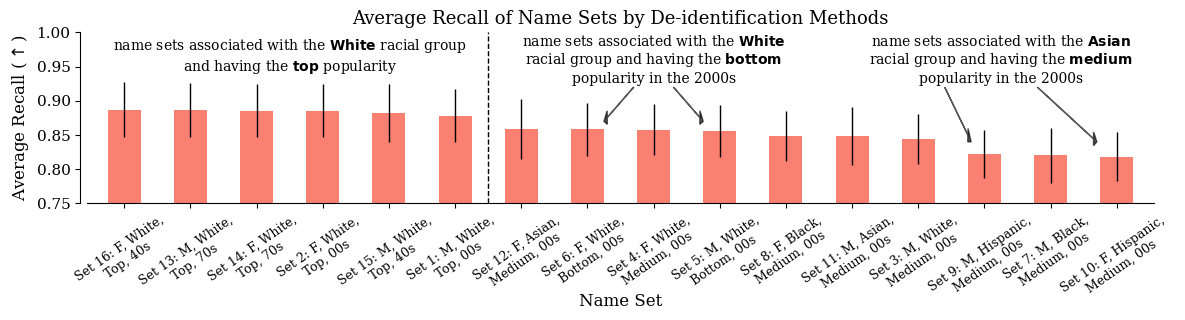

In [11]:
# plot the average recall and standard error of each set by models

index2description = {1: 'Set 1: M, White,\nTop, 00s', 2: 'Set 2: F, White,\nTop, 00s',
                     3: 'Set 3: M, White,\nMedium, 00s', 4: 'Set 4: F, White,\nMedium, 00s',
                     5: 'Set 5: M, White,\nBottom, 00s', 6: 'Set 6: F, White,\nBottom, 00s',
                     7: 'Set 7: M, Black,\nMedium, 00s', 8: 'Set 8: F, Black,\nMedium, 00s',
                     9: 'Set 9: M, Hispanic,\nMedium, 00s', 10: 'Set 10: F, Hispanic,\nMedium, 00s',
                     11: 'Set 11: M, Asian,\nMedium, 00s', 12: 'Set 12: F, Asian,\nMedium, 00s',
                     13: 'Set 13: M, White,\nTop, 70s', 14: 'Set 14: F, White,\nTop, 70s',
                     15: 'Set 15: M, White,\nTop, 40s', 16: 'Set 16: F, White,\nTop, 40s'}

fontsize = 12
fig, ax = plt.subplots(1,1, figsize=(0.75*len(name_sets), 3.3))
color = sns.color_palette("dark:salmon_r", len(name_sets))[0]
sns.despine(ax=ax, offset=dict(left=5))
width, middle = 0.5, np.arange(len(name_sets))
ax.bar(middle, means, width=width, color=color, yerr=stderrs, error_kw=dict(ecolor='black', elinewidth=1))

ax.margins(x=0.02)
ax.set_ylim([0.75, 1])
ax.tick_params(axis='y', which='major', labelsize=fontsize-1)
ax.set_xticks(range(len(name_sets)))
ax.set_xticklabels([index2description[index] if index in index2description else index for index in performance2rank]) #########
ax.tick_params(axis='x', which='major', labelsize=fontsize-3, labelrotation=35)
ax.set_xlabel('Name Set', fontsize=fontsize, labelpad=-10)
ax.set_ylabel(r'Average Recall ($\uparrow$)', fontsize=fontsize)
ax.set_title('Average Recall of Name Sets by De-identification Methods', fontsize=fontsize+1)

ax.text(2.5, 0.965, ha='center', va='center', fontsize=fontsize-2, 
        s=r'name sets associated with the $\bf{White}$'+' racial group\nand having the '+r'$\bf{top}$ popularity')
ax.text(8, 0.96, ha='center', va='center', fontsize=fontsize-2, 
        s=r'name sets associated with the $\bf{White}$'+'\nracial group and having the '+r'$\bf{bottom}$'+'\npopularity in the 2000s')
ax.text(13.25, 0.96, ha='center', va='center', fontsize=fontsize-2,
        s=r'name sets associated with the $\bf{Asian}$'+'\nracial group and having the '+r'$\bf{medium}$'+'\npopularity in the 2000s')
ax.axvline(x=5.5, linestyle='--', linewidth=1, color='k')
ax.arrow(7.7, 0.92, 7.25-7.7, 0.87-0.92, width=1e-5, head_width=0.02, head_length=0.05,
           length_includes_head=True, alpha=0.65, linewidth=1, color='k')
ax.arrow(8.3, 0.92, 8.75-8.3, 0.87-0.92, width=1e-5, head_width=0.02, head_length=0.05,
           length_includes_head=True, alpha=0.65, linewidth=1, color='k')
ax.arrow(12.4, 0.92, 12.8-12.4, 0.84-0.92, width=1e-5, head_width=0.02, head_length=0.05,
           length_includes_head=True, alpha=0.65, linewidth=1, color='k')
ax.arrow(13.8, 0.92, 14.7-13.8, 0.84-0.92, width=1e-5, head_width=0.02, head_length=0.05,
           length_includes_head=True, alpha=0.65, linewidth=1, color='k')

plt.tight_layout()
plt.savefig('Figure/set_recall.pdf')
plt.show()
plt.close(fig)